In [2]:
!pip install scipy

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy.signal.windows import gaussian
from scipy.ndimage import gaussian_filter

def praat_spectrogram(
    filepath,
    sr=None,
    window_length_sec=0.005,
    hop_length_sec=0.002,
    max_freq=5000,
    dynamic_range=50,
    preemph_cutoff=50,
    cmap='gray_r',
    show_colorbar=True,
    show_plot=True
):
    # Load audio
    y, sr = librosa.load(filepath, sr=sr)

    # Pre-emphasis (as in Praat, starting from 50 Hz)
    pre_emph_coeff = np.exp(-2 * np.pi * preemph_cutoff / sr)
    y = np.append(y[0], y[1:] - pre_emph_coeff * y[:-1])

    # Window and hop lengths in samples
    win_length = int(window_length_sec * sr)
    hop_length = int(hop_length_sec * sr)

    # FFT size (next power of 2)
    n_fft = 2 ** int(np.ceil(np.log2(win_length)))

    # Gaussian window (similar to Praat)
    window = gaussian(win_length, std=win_length / 6)

    # Compute STFT
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length,
                     win_length=win_length, window=window)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

    # Apply dynamic range limit
    S_db[S_db < (np.max(S_db) - dynamic_range)] = np.max(S_db) - dynamic_range

    # --- Praat-style smoothing ---
    # Time smoothing σ = 0.0025 s (half of window), converted to frames
    sigma_time = 0.0025 / hop_length_sec

    # Frequency smoothing σ = 1.5 bins (based on bin width)
    sigma_freq = 1.5

    # 2D Gaussian filter
    S_db_smooth = gaussian_filter(S_db, sigma=[sigma_freq, sigma_time])

    # Plot
    if show_plot:
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(S_db_smooth, sr=sr, hop_length=hop_length,
                                 x_axis='time', y_axis='hz', cmap=cmap)
        if show_colorbar:
            plt.colorbar(label='dB')
        plt.title('Praat-like Spectrogram (Smoothed)')
        plt.ylim(0, max_freq)
        plt.tight_layout()
        plt.show()

    return S_db_smooth, sr


In [8]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

example = librosa.example('libri1')

In [9]:
example

'/root/.cache/librosa/5703-47212-0000.ogg'

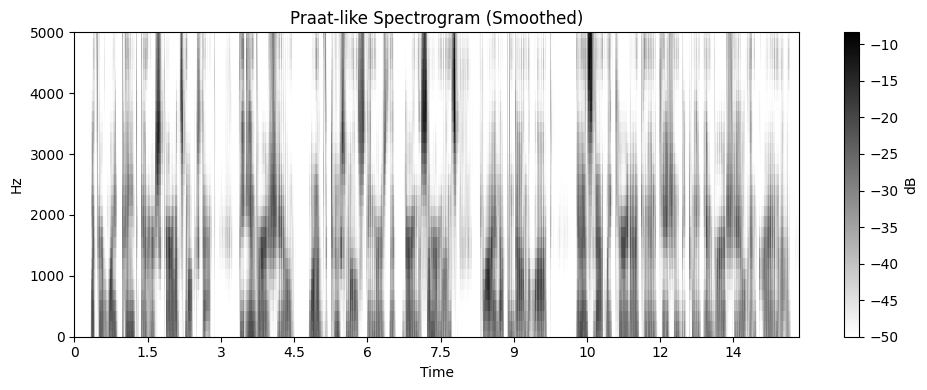

(array([[-50.        , -50.        , -50.        , ..., -49.99548692,
         -49.99951954, -49.99997303],
        [-50.        , -50.        , -50.        , ..., -49.9968944 ,
         -49.99965365, -49.9999771 ],
        [-50.        , -50.        , -50.        , ..., -49.99761777,
         -49.99949067, -49.99990566],
        ...,
        [-50.        , -50.        , -50.        , ..., -50.        ,
         -50.        , -50.        ],
        [-50.        , -50.        , -50.        , ..., -50.        ,
         -50.        , -50.        ],
        [-50.        , -50.        , -50.        , ..., -50.        ,
         -50.        , -50.        ]]),
 22050)

In [16]:
praat_spectrogram(example)